In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.cluster import KMeans,MeanShift,MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.compose import ColumnTransformer

import category_encoders as ce

In [2]:
#read in data
customers = pd.read_csv('./data/customers.csv')
customers.head()

,customer_ID,sex,registration_date,first_rent_date,customer_age
0,1,female,01.09.20 00:14,01.09.20 01:47,34
1,2,male,31.08.20 21:13,31.08.20 23:50,28
2,3,male,31.08.20 20:53,31.08.20 23:06,23
3,4,female,31.08.20 20:50,31.08.20 23:45,24
4,5,female,31.08.20 20:45,31.08.20 23:33,28


In [3]:
customers.dtypes

customer_ID           int64
sex                  object
registration_date    object
first_rent_date      object
customer_age          int64
dtype: object

In [4]:
print('The number of customers in customers data is {}'.format(customers.shape[0]))

The number of customers in customers data is 10000


In [5]:
#convert registration_date and first_rent_date to datetime format

customers[["registration_date","first_rent_date"]] = customers[["registration_date","first_rent_date"]].apply(pd.to_datetime)

In [6]:
rentals = pd.read_csv('./data/rentals.csv')
rentals.head()

,place,package,rent_id,customer_ID,rental_start_date,distance,duration,price
0,Paris,minute_based_rental,d9b784a3-4,17091,15.04.20,2,7,2.07
1,Madrid,minute_based_rental,0906b4a9-e,66145,15.02.20,4,12,2.38
2,Madrid,minute_based_rental,43d2d8c0-6,62554,24.07.20,4,15,4.10
3,Paris,minute_based_rental,b92469d5-0,31508,13.01.20,10,27,5.40
4,Madrid,minute_based_rental,b3c72862-3,66064,08.06.20,2,8,1.79


In [7]:
print('The number of rents in rentals data is {}'.format(rentals.shape[0]))

The number of rents in rentals data is 100000


#### Feature Engineering: Creating New Features

In [8]:
#merge the 2 dataframe's together.

df = rentals.merge(customers, on='customer_ID')
df.head()

,place,package,rent_id,customer_ID,rental_start_date,distance,duration,price,sex,registration_date,first_rent_date,customer_age
0,Madrid,minute_based_rental,4071ef0d-6,4729,22.07.20,7,28,6.23,female,2020-05-25 01:15:00,2020-05-29 17:13:00,23
1,Madrid,minute_based_rental,331ba874-8,4729,12.08.20,4,11,2.64,female,2020-05-25 01:15:00,2020-05-29 17:13:00,23
2,Madrid,minute_based_rental,4071ef0d-6,4729,22.07.20,7,28,6.23,female,2020-05-25 01:15:00,2020-05-29 17:13:00,23
3,Madrid,minute_based_rental,fbcb4dfb-6,4729,26.08.20,43,75,19.21,female,2020-05-25 01:15:00,2020-05-29 17:13:00,23
4,Madrid,minute_based_rental,38875c74-d,4729,24.07.20,16,29,7.69,female,2020-05-25 01:15:00,2020-05-29 17:13:00,23


In [9]:
#convert rental_start_date,registration_datetime_local, Rental_First_Datetime_local to date-type

df[["rental_start_date", "registration_date", "first_rent_date"]] = df[["rental_start_date", "registration_date", "first_rent_date"]].apply(pd.to_datetime,errors='coerce')


#extract rental_start_month and rental_start_year from rental_start_date
df['rental_start_month'] = pd.DatetimeIndex(df["rental_start_date"]).month
df['rental_start_year'] = pd.DatetimeIndex(df["rental_start_date"]).year

In [10]:
print('The latest date in the dataframe is {}'.format(df["rental_start_date"].max()))
print('The earliest date in the dataframe is {}'.format(df["rental_start_date"].min()))

The latest date in the dataframe is 2020-12-08 00:00:00
The earliest date in the dataframe is 2020-01-02 00:00:00


In [11]:
#calculate the monthly average rent count from df
df_info = df.groupby(['customer_ID','rental_start_month']).agg({'rent_id':'nunique'}).reset_index(drop=False).groupby('customer_ID')['rental_start_month'].sum()/12

#calculate the monthly revenue from each customer from df
df_info_mean = df.groupby(['customer_ID','rental_start_month']).agg({'price':'mean',
                                                                    'duration':'mean'}).reset_index(drop=False)
                          
#merge new info with customer data    
customers = customers.merge(df_info,on='customer_ID').merge(df_info_mean,on='customer_ID').rename(columns=
                                                                                                  {'rental_start_month_x':'monthly_rent_average',
                                                                                                   'price':'mean_monthly_rental_revenue',
                                                                                                  'duration':'mean_monthly_rental_duration'})

In [12]:
#create day distance registration to rental
customers['registration_to_rental_days'] = (customers['registration_date'] - customers['first_rent_date']).dt.days

#drop all datetime columns and ID columns (rental_ID & customer_ID)
customers_ = customers.drop(['rental_start_month_y','registration_date','first_rent_date','customer_ID'],axis=1)

customers_.head()

,sex,customer_age,monthly_rent_average,mean_monthly_rental_revenue,mean_monthly_rental_duration,registration_to_rental_days
0,female,34,0.666667,3.8,32.0,-1
1,male,19,0.666667,0.0,10.0,-1
2,male,37,0.666667,0.0,25.0,-1
3,male,41,0.666667,0.0,20.0,-1
4,male,22,0.666667,0.0,43.0,-1


#### Model Development

In [13]:
#initialize the ordinal_encoder for Gender
ce_ord = ce.OrdinalEncoder(cols = ['sex'])

#set up the column transfomer
ct = ColumnTransformer([
        ('transformer', Normalizer(norm='l1'), ['customer_age', 'mean_monthly_rental_revenue','mean_monthly_rental_duration','registration_to_rental_days'])
    ], remainder='passthrough')

In [14]:
#instantiate the clustering model
kmeans = KMeans(n_clusters = 4,algorithm='full')

#build a pipeline for the kmeans clustering model
pipe_kmeans = Pipeline([('ordinal_encode',ce_ord),
                        ('transformer', ct),
                        ('kmeans', kmeans)])


#fit the k-means model
pipe_kmeans.fit(customers_)

#assign a cluster to each customer using the kmeans cluster
customer_cluster_kmeans = pipe_kmeans.predict(customers_)

In [15]:
#retrieve and count of each cluster group of the kmeans cluster
unique, counts = np.unique(customer_cluster_kmeans, return_counts=True)
dict(zip(unique, counts))

{0: 2054, 1: 3461, 2: 1985, 3: 615}

In [16]:
#build a mean MiniBatchKMeans model
minibatch = MiniBatchKMeans(n_clusters=4,batch_size=1000)

#build a pipeline for the kmeans clustering model
pipe_minibatch = Pipeline([('ordinal_encode',ce_ord),
                           ('transformer', ct),
                          ('minbatch', minibatch)])


#fit the mean shift model
pipe_minibatch.fit(customers_)

#assign a cluster to each customer using the shift model
customer_cluster_minibatch = pipe_minibatch.predict(customers_)

In [17]:
#retrieve and count of each cluster group of the minibatch KMeans model
unique, counts = np.unique(customer_cluster_minibatch, return_counts=True)
dict(zip(unique, counts))

{0: 2030, 1: 2068, 2: 434, 3: 3583}

In [18]:
#plug in the clusters generated by the kmeans clustering algorithm
customers['customer_group'] = customer_cluster_kmeans

customers.head(10)

,customer_ID,sex,registration_date,first_rent_date,customer_age,monthly_rent_average,rental_start_month_y,mean_monthly_rental_revenue,mean_monthly_rental_duration,registration_to_rental_days,customer_group
0,1,female,2020-01-09 00:14:00,2020-01-09 01:47:00,34,0.666667,8,3.80,32.0,-1,2
1,6,male,2020-08-31 19:56:00,2020-08-31 21:00:00,19,0.666667,8,0.00,10.0,-1,1
2,8,male,2020-08-31 17:34:00,2020-08-31 18:43:00,37,0.666667,8,0.00,25.0,-1,1
3,23,male,2020-08-30 18:20:00,2020-08-30 20:20:00,41,0.666667,8,0.00,20.0,-1,1
4,24,male,2020-08-30 16:52:00,2020-08-30 18:22:00,22,0.666667,8,0.00,43.0,-1,1
5,32,male,2020-08-30 12:41:00,2020-08-30 16:12:00,27,0.666667,8,7.69,36.0,-1,1
6,35,male,2020-08-30 12:31:00,2020-08-30 20:24:00,32,0.666667,8,7.67,48.0,-1,1
7,38,female,2020-08-30 11:54:00,2020-08-30 12:26:00,24,0.666667,8,0.00,1.0,-1,2
8,41,male,2020-08-30 10:45:00,2020-08-30 11:59:00,33,0.666667,8,0.00,40.0,-1,1
9,43,male,2020-08-30 10:05:00,2020-08-31 09:45:00,52,0.666667,8,4.53,30.0,-1,1


In [19]:
customers.customer_group.value_counts()

1    3461
0    2054
2    1985
3     615
Name: customer_group, dtype: int64

#### Explore Model Results

In [20]:
#Explore the model clustering results - customer groups on monthly_rent_average and registration_to_rental_days
np.round(customers.groupby(['customer_group'])[['monthly_rent_average','registration_to_rental_days']].describe(),2)

monthly_rent_average                                            \
                              count  mean   std   min   25%   50%   75%   max   
customer_group                                                                  
0                            2054.0  2.12  0.42  1.50  1.75  2.08  2.42  3.00   
1                            3461.0  0.70  0.37  0.08  0.50  0.67  1.00  1.58   
2                            1985.0  0.77  0.41  0.08  0.50  0.67  1.08  1.58   
3                             615.0  3.96  0.76  3.08  3.33  3.75  4.50  6.42   

               registration_to_rental_days                                     \
                                     count    mean      std    min   25%  50%   
customer_group                                                                  
0                                   2054.0  113.96   945.76 -321.0 -18.0 -1.0   
1                                   3461.0   86.57   845.52 -340.0 -13.0 -1.0   
2                                   1985.0   -9.25    76.40 -339.0 -19.0 -1.0   
3                                    615.0  147.51  1110.53 -294.0  -9.0 -1.0   

                             
                75%     max  
customer_group               
0              -1.0  7641.0  
1              -1.0  7641.0  
2              -1.0   333.0  
3              -1.0  7412.0

In [21]:
#Explore the model clustering results - customer groups on mean_monthly_rental_revenue and mean_monthly_rental_duration
np.round(customers.groupby(['customer_group'])[['mean_monthly_rental_revenue','mean_monthly_rental_duration']].describe(),2)

mean_monthly_rental_revenue                                  \
                                     count   mean     std  min   25%   50%   
customer_group                                                               
0                                   2054.0   7.73   13.84  0.0  3.00  4.82   
1                                   3461.0  13.91  186.41  0.0  2.00  4.33   
2                                   1985.0   8.99   49.46  0.0  2.05  4.47   
3                                    615.0   7.50   15.76  0.0  2.93  4.59   

                               mean_monthly_rental_duration                   \
                 75%       max                        count    mean      std   
customer_group                                                                 
0               8.15    336.24                       2054.0   49.68   150.31   
1               7.97  10327.59                       3461.0  169.62  1961.44   
2               7.82   1759.86                       1985.0   97.19  1232.52   
3               7.73    343.96                        615.0  113.08  1685.42   

                                                 
                min   25%    50%   75%      max  
customer_group                                   
0               0.0  14.0  22.00  35.5   2884.0  
1               0.0  14.0  22.00  38.0  48296.0  
2               0.0  15.0  23.00  37.0  48019.0  
3               1.0  14.0  20.67  34.0  41751.0

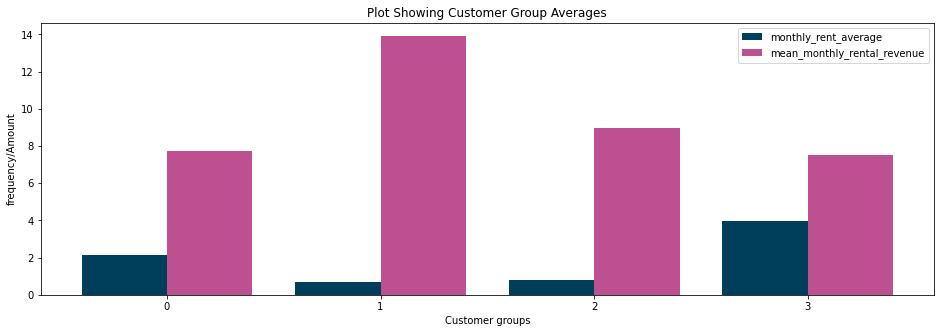

In [22]:
#visualizations

#calculate the averages over the groups
mean_df = customers.groupby(['customer_group'])['monthly_rent_average','registration_to_rental_days','mean_monthly_rental_revenue','mean_monthly_rental_duration'].mean().reset_index()


#plot the monthly_rent_average and mean_monthly_rental_revenue
plt.figure(figsize = (16,5))

X = list(mean_df.customer_group)
rentals = list(mean_df.monthly_rent_average)
revenue = list(mean_df.mean_monthly_rental_revenue)
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, rentals, 0.4, label = 'monthly_rent_average',color='#003f5c')
plt.bar(X_axis + 0.2, revenue, 0.4, label = 'mean_monthly_rental_revenue',color='#bc5090')

plt.xticks(X_axis, X)
plt.xlabel("Customer groups")
plt.ylabel("frequency/Amount")
plt.title("Plot Showing Customer Group Averages")
plt.legend()
plt.show()

#### Determine Optimal Number of Clusters

In [23]:
#copy the customers_ into optimize_df
optimize_df = customers_.copy()

#transform the sex column
optimize_df = ce_ord.fit_transform(optimize_df) 

#column transformer
optimize_df = ct.fit_transform(optimize_df) 

##### Elbow Method

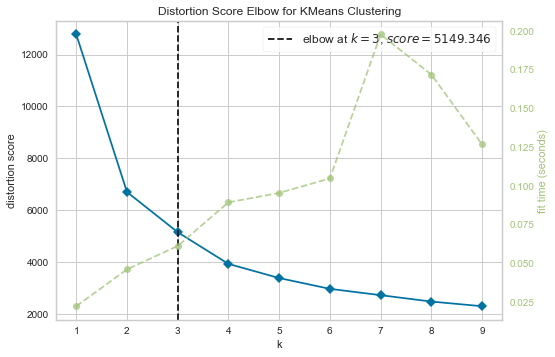

In [24]:
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(pipe_kmeans[2], k=(1,10))  #pipe_kmeans[2] is the model

visualizer.fit(optimize_df)

visualizer.show()

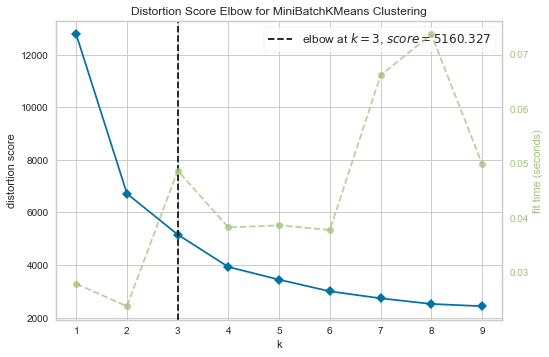

In [26]:
visualizer = KElbowVisualizer(pipe_minibatch[2], k=(1,10))  #pipe_kmeans[2] is the model

visualizer.fit(optimize_df)

visualizer.show()

##### Silhouette Coefficient

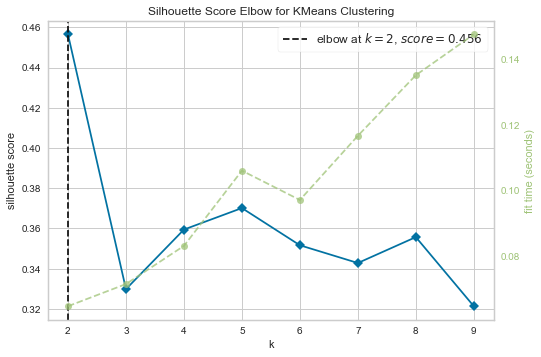

In [28]:
visualizer_sil = KElbowVisualizer(pipe_kmeans[2], k=(2,10),metric='silhouette', timings= True)  #pipe_kmeans[2] is the model

visualizer_sil.fit(optimize_df)

visualizer_sil.show()

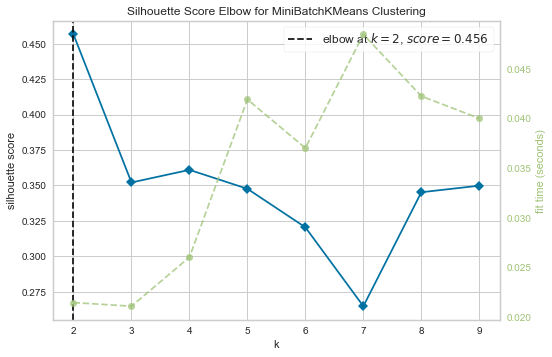

In [29]:
visualizer_sil = KElbowVisualizer(pipe_minibatch[2], k=(2,10),metric='silhouette', timings= True)  #pipe_kmeans[2] is the model

visualizer_sil.fit(optimize_df)

visualizer_sil.show()

##### Calinski-Harabasz Index

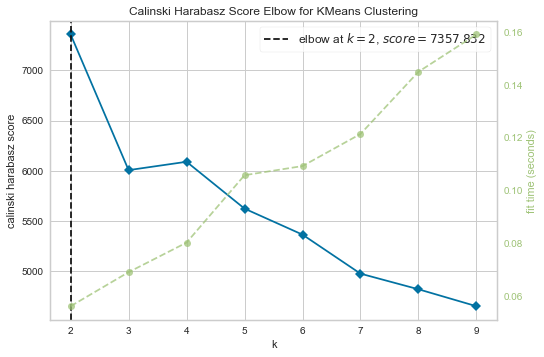

In [31]:
visualizer_cal = KElbowVisualizer(pipe_kmeans[2], k=(2,10),metric='calinski_harabasz', timings= True)  #pipe_kmeans[2] is the model

visualizer_cal.fit(optimize_df)

visualizer_cal.show()

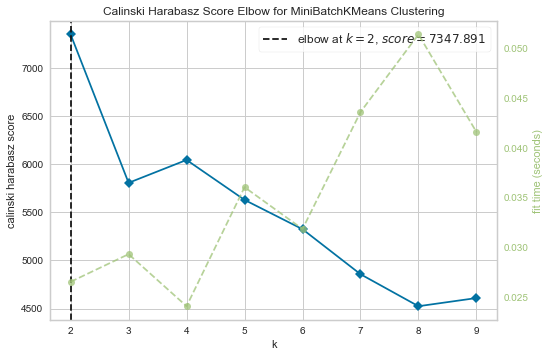

In [32]:
visualizer_cal = KElbowVisualizer(pipe_minibatch[2], k=(2,10),metric='calinski_harabasz', timings= True)  #pipe_kmeans[2] is the model

visualizer_cal.fit(optimize_df)

visualizer_cal.show()